In [2]:
! pip install python-mnist

In [32]:
! pip install scikit-image

In [77]:
! pip install imgaug

     |████████████████████████████████| 948 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 28.2 MB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 51.2 MB/s eta 0:00:01


In [59]:
torch.cuda.set_device(1)

In [60]:
torch.cuda.current_device()

1

In [1]:
from mnist import MNIST
import numpy as np
mndata = MNIST('Data/MNIST')
X_train, y_train = mndata.load_training()
X_train = np.array(X_train).reshape(60000,28,28)
y_train = np.array(y_train)

In [19]:
X_test, y_test = mndata.load_testing()
X_test = np.array(X_test).reshape(10000,28,28)
y_test = np.array(y_test)

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from skimage.metrics import structural_similarity as ssim

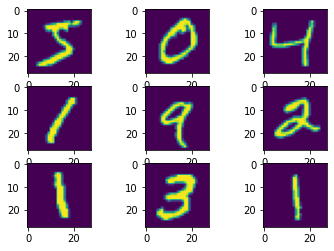

In [182]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [183]:
ssim(X_train[0], X_train[3], data_range=255)

0.19064748123354602

In [5]:
np.bincount(np.array(y_train))

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from collections import OrderedDict
from torch.optim import Adam, SGD
from torch.autograd import Variable


In [8]:
pre_X = X_train
X_train = np.zeros(shape=(60000,28,28,3))
for i in range(X_train.shape[0]):
    img = np.stack((pre_X[i],)*3, axis=-1)
    X_train[i] = img/255
del pre_X

In [20]:
pre_X_test = X_test
X_test = np.zeros(shape=(10000,28,28,3))
for i in range(X_test.shape[0]):
    img = np.stack((pre_X_test[i],)*3, axis=-1)
    X_test[i] = img/255

In [10]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
torch.manual_seed(1)
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader 

In [11]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(3, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)

In [12]:
def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    

In [13]:
def train_res(epoch):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += criterion(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
    

In [14]:
def print_scores(p, r, f1, a, batch_size):
    # just an utility printing function
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [15]:
from sklearn.model_selection import train_test_split
def make_data_loaders(X_train, y_train, batch_size):
    X_train = X_train.reshape(X_train.shape[0],3,28,28)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)
    data_transform = Compose([Resize((224, 224))])
    X_train = torch.from_numpy(X_train).type(torch.float)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)

    X_val = torch.from_numpy(X_val).type(torch.float)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor)

    train_d = torch.utils.data.TensorDataset(X_train,y_train)
    train_loader = torch.utils.data.DataLoader(train_d, batch_size = batch_size, shuffle = False)

    val_d = torch.utils.data.TensorDataset(X_val,y_val)
    val_loader = torch.utils.data.DataLoader(val_d,batch_size = batch_size, shuffle = False)
    return train_loader, val_loader

In [21]:
X_test = X_test.reshape(X_test.shape[0],3,28,28)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)
test_d = torch.utils.data.TensorDataset(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test_d, batch_size = batch_size, shuffle = False)

In [65]:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_train, y_train, batch_size)

In [133]:
# model:
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.7530724606414636, validation loss: 0.22296786308288574
	     precision: 0.9300
	        recall: 0.9279
	            F1: 0.9245
	      accuracy: 0.9293



Epoch 2/5, training loss: 0.17975678717510568, validation loss: 0.17112718522548676
	     precision: 0.9484
	        recall: 0.9480
	            F1: 0.9448
	      accuracy: 0.9485



Epoch 3/5, training loss: 0.13550300863467984, validation loss: 0.13501329720020294
	     precision: 0.9611
	        recall: 0.9611
	            F1: 0.9589
	      accuracy: 0.9615



Epoch 4/5, training loss: 0.10692117489667402, validation loss: 0.12399967759847641
	     precision: 0.9649
	        recall: 0.9638
	            F1: 0.9624
	      accuracy: 0.9646



Epoch 5/5, training loss: 0.09705908715414505, validation loss: 0.18632984161376953
	     precision: 0.9540
	        recall: 0.9512
	            F1: 0.9489
	      accuracy: 0.9513
Training time: 620.172180891037s


In [134]:
def compute_test(model, test_loader, c):
    class_correct = 0
    class_total = 0
    model.eval()
    test_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            test_losses += criterion(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction

            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                    (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
            class_correct += np.sum((predicted_classes.cpu().data.numpy() == c) & (y.cpu().data.numpy() == c))
            class_total += np.sum(y.cpu().data.numpy() == c)
            
            
    print(f"test loss: {test_losses/len(test_loader)}")
    print_scores(precision, recall, f1, accuracy, batch_size)
    print(f"accuracy for class {c}: {class_correct/class_total}")

In [135]:
compute_test(model, test_loader, 4)

test loss: 0.6293444633483887
	     precision: 0.8965
	        recall: 0.8777
	            F1: 0.8572
	      accuracy: 0.8798
accuracy for class 5: 0.9473094170403588


## Data Augmentation

Simulate images for imbalanced classes

In [115]:
from config import get_arguments
from SinGAN.manipulate import *
from SinGAN.training import *
import SinGAN.functions as functions

In [116]:
imb_class_list = np.random.randint(low=0, high=10, size=2)

In [117]:
c = 4

In [118]:
class_indices = np.where(y_train == c)[0]

In [119]:
to_replace = np.random.choice(class_indices, int(0.99*class_indices.size), replace=False)

In [120]:
left = np.setdiff1d(class_indices, to_replace)

Calculate SSIM

In [121]:
def av_SSIM(images, other=None, pairs=100):
    l = np.zeros(pairs)
    if other:
        ind_a = np.random.choice(list(range(images.shape[0])), size = pairs)
        ind_b = np.random.choice(list(range(other.shape[0])), size = pairs)
    else:
        ind_a = np.random.choice(list(range(images.shape[0])), size = pairs)
        ind_b = np.zeros(pairs, dtype=int)
        count = 0
        while count < pairs:
            ind_b[count] = np.random.choice(list(range(images.shape[0])), size = 1)[0]
            if ind_a[count] != ind_b[count]:
                count += 1
    
    for i in range(pairs):
        if other:
            l[i] = ssim(images[ind_a[i]], other[ind_b[i]], data_range=1, multichannel=True)
        else:
            l[i] = ssim(images[ind_a[i]], images[ind_b[i]], data_range=1, multichannel=True)
    
    return l.mean()
              

In [122]:
av_SSIM(X_train[y_train==5])

0.2365590549850124

### Train with imbalanced data

In [136]:
X_aug = X_train.copy()
y_aug = y_train.copy()

In [137]:
X_aug = np.delete(X_aug, to_replace, axis=0)
y_aug = np.delete(y_aug,to_replace, axis=0)

In [138]:
# model:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_aug, y_aug, batch_size)
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.6924087229100141, validation loss: 0.3018747866153717
	     precision: 0.9049
	        recall: 0.9012
	            F1: 0.8969
	      accuracy: 0.9131



Epoch 2/5, training loss: 0.1979466464361336, validation loss: 0.18594135344028473
	     precision: 0.9319
	        recall: 0.9328
	            F1: 0.9291
	      accuracy: 0.9446



Epoch 3/5, training loss: 0.1513169458552426, validation loss: 0.16778044402599335
	     precision: 0.9413
	        recall: 0.9416
	            F1: 0.9386
	      accuracy: 0.9527



Epoch 4/5, training loss: 0.1302871731354761, validation loss: 0.16370972990989685
	     precision: 0.9426
	        recall: 0.9443
	            F1: 0.9411
	      accuracy: 0.9561



Epoch 5/5, training loss: 0.11498237061897791, validation loss: 0.14691367745399475
	     precision: 0.9468
	        recall: 0.9489
	            F1: 0.9453
	      accuracy: 0.9599
Training time: 550.8459274768829s


In [139]:
compute_test(model, test_loader, c)

test loss: 0.5651249289512634
	     precision: 0.8240
	        recall: 0.8680
	            F1: 0.8334
	      accuracy: 0.8694
accuracy for class 4: 0.010183299389002037


### Train with baseline data augmentation

In [43]:
from imgaug import augmenters as iaa
seq = iaa.Sequential([
    #iaa.Fliplr(0.5), # horizontal flips 
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) 

In [95]:
X_aug = X_train.copy()
y_aug = y_train.copy()
for i in range(to_replace.size):
    X_aug[to_replace[i]] = seq(image = X_aug[left][i % left.size])

In [96]:
av_SSIM(X_aug[to_replace])

0.10891037505014035

In [46]:
# model:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_aug, y_aug, batch_size)
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.8278292954630322, validation loss: 0.36879944801330566
	     precision: 0.8963
	        recall: 0.8854
	            F1: 0.8775
	      accuracy: 0.8855



Epoch 2/5, training loss: 0.17842213711804814, validation loss: 0.23238767683506012
	     precision: 0.9308
	        recall: 0.9255
	            F1: 0.9204
	      accuracy: 0.9240



Epoch 3/5, training loss: 0.13136248260322544, validation loss: 0.13150177896022797
	     precision: 0.9628
	        recall: 0.9622
	            F1: 0.9604
	      accuracy: 0.9621



Epoch 4/5, training loss: 0.11048736835312511, validation loss: 0.15855902433395386
	     precision: 0.9546
	        recall: 0.9540
	            F1: 0.9512
	      accuracy: 0.9535



Epoch 5/5, training loss: 0.09233972311123377, validation loss: 0.23740868270397186
	     precision: 0.9429
	        recall: 0.9400
	            F1: 0.9362
	      accuracy: 0.9403
Training time: 759.3925712108612s


In [47]:
compute_test(model, test_loader,c)

test loss: 0.2585849463939667
	     precision: 0.9353
	        recall: 0.9320
	            F1: 0.9286
	      accuracy: 0.9340
accuracy for class 5: 0.8195067264573991


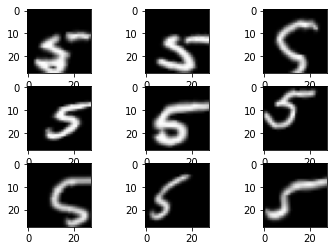

In [45]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_aug[to_replace[i]])
plt.show()

### Train with SinGAN

In [123]:
import MNIST_SinGAN

In [125]:
torch.cuda.set_device(0)
start_ts = time.time()
simulated_imgs = MNIST_SinGAN.generate_data(class_label = c, generate_size = to_replace.size, sample_size=8)
print(time.time()-start_ts)
simulated_imgs = np.array(simulated_imgs[:to_replace.size])

Random Seed:  1
MNIST_4_input_0.png
/home/jupyter/output/MNIST_4_input_0.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_4_input_1.png
/home/jupyter/output/MNIST_4_input_1.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_4_input_2.png
/home/jupyter/output/MNIST_4_input_2.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_4_input_3.png
/home/jupyter/output/MNIST_4_input_3.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_4_input_4.png
/home/jupyter/output/MNIST_4_input_4.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_4_input_5.png
/home/jupyter/output/MNIST_4_input_5.png/layer=6, additional_scale=False, iteration=2000, scale_factor=0.75, alpha=10
Random Seed:  1
MNIST_4_input_6.png
/home/jupyter/output/MNIST_4_input_6.png

In [126]:
torch.cuda.set_device(1)

In [127]:
simulated_imgs.shape

(5783, 28, 28, 3)

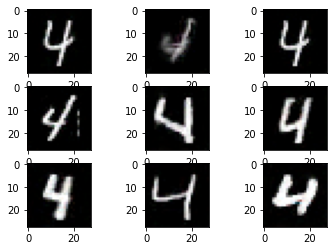

In [128]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(simulated_imgs[i])
plt.show()

In [129]:
av_SSIM(simulated_imgs)

0.33630319563757616

In [130]:
X_aug = X_train.copy()
y_aug = y_train.copy()
X_aug[to_replace] = simulated_imgs

In [131]:
# model:
batch_size = 100
train_loader, val_loader = make_data_loaders(X_aug, y_aug, batch_size)
model = MnistResNet()

epochs = 5
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_ts = time.time()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    train_res(epoch)
    
print(f"Training time: {time.time()-start_ts}s")


Epoch 1/5, training loss: 0.7605730159746276, validation loss: 0.19757726788520813
	     precision: 0.9428
	        recall: 0.9417
	            F1: 0.9387
	      accuracy: 0.9424



Epoch 2/5, training loss: 0.17357577240301503, validation loss: 0.13794343173503876
	     precision: 0.9601
	        recall: 0.9607
	            F1: 0.9582
	      accuracy: 0.9607



Epoch 3/5, training loss: 0.13816641379147768, validation loss: 0.1551569700241089
	     precision: 0.9545
	        recall: 0.9542
	            F1: 0.9512
	      accuracy: 0.9548



Epoch 4/5, training loss: 0.11587134315218363, validation loss: 0.12985514104366302
	     precision: 0.9642
	        recall: 0.9642
	            F1: 0.9620
	      accuracy: 0.9647



Epoch 5/5, training loss: 0.09832261219206784, validation loss: 0.12670005857944489
	     precision: 0.9657
	        recall: 0.9651
	            F1: 0.9633
	      accuracy: 0.9658
Training time: 619.6013305187225s


In [132]:
compute_test(model, test_loader, c)

test loss: 0.27077221870422363
	     precision: 0.9444
	        recall: 0.9358
	            F1: 0.9313
	      accuracy: 0.9362
accuracy for class 4: 0.6771894093686355
